# How are in-demand skills trending for Data Analyst?
## Methodology
1. Load and clean-up data
1. Aggregate skill counts monthly
2. Re-analize based on percentage of total jobs
3. Plot the monthly skill demand

## 1. Load and clean-up data

In [204]:
# Importing libraries
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # Skills from str to list

In [205]:
# Filter for Data Analyst roles
df_DA = df[df['job_title_short']=='Data Analyst'].copy()

## 2. Aggregate skill count monthly

In [206]:
# Add 'job_posted_date' column for aggregation
df_DA['job_posted_month'] = df_DA['job_posted_date'].dt.month

# Explode for single skill in a row
df_exploded = df_DA.explode('job_skills')

In [207]:
# Group by month and skills and count values
df_groupped = df_exploded.groupby(by=['job_posted_month','job_skills']).size().reset_index(name='skill_count')

In [227]:
# Create a pivot table with calulated number of skills per month
df_pivot = df_exploded.pivot_table(
    index='job_posted_month',
    columns='job_skills',
    aggfunc='size',
    fill_value=0)

# Add a total column to filter top 6 skills
df_pivot.loc['total'] = df_pivot.sum()
df_pivot = df_pivot[df_pivot.loc['total'].sort_values(ascending=False).index]
df_pivot = df_pivot.iloc[:, :6] # Take only top 6 skills
df_pivot = df_pivot.drop('total') # Drop total row

## 3. Re-analize based on percentage of total jobs

In [228]:
# NUmber of job postings per group
DA_totals = df_DA.groupby('job_posted_month').size()

# Change numerical values to a percent of all 
df_percentage = df_pivot.div(DA_totals,axis='index')*100


In [229]:
# Change number of a month on format 'mmm'
df_plot = df_percentage.reset_index(names='month_no')
df_plot['month'] = pd.to_datetime(df_plot['month_no'].astype(str)+'-01-2023')
df_plot['month'] = df_plot['month'].dt.strftime('%b')
df_plot.set_index('month', inplace=True)
df_plot.drop('month_no', axis='columns', inplace=True)

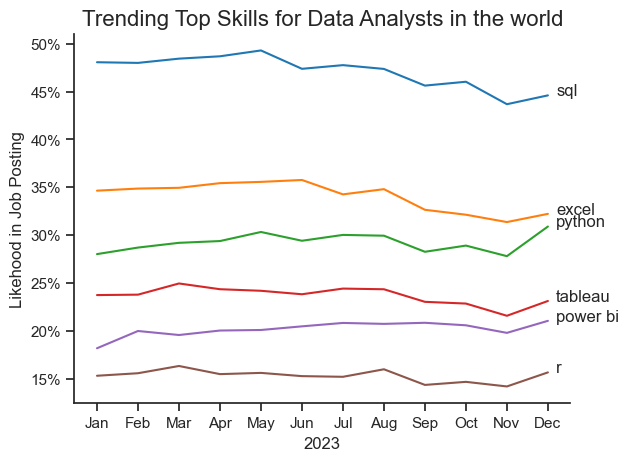

In [230]:
sns.lineplot(data=df_plot, dashes=False, palette='tab10')
sns.set_theme(style='ticks')
sns.despine()

plt.title('Trending Top Skills for Data Analysts in the world', fontsize=16)
plt.ylabel('Likehood in Job Posting')
plt.xlabel('2023')
plt.legend().remove()

#Change values to %
from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

#Add data labels
for skill in df_plot.columns:
    plt.text(11.2, df_plot[skill].iloc[-1], skill)

plt.show()